## Import library

In [1]:
import os
from openpose import OpenposeDetector
from PIL import Image
from utils import HWC3, resize_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import io
apply_openpose = OpenposeDetector()


## Function to define motion part for segmentation

In [2]:
def define_motion_part(image):
    img_width, img_height = image.size
    print(f"Image width: {img_width}, height: {img_height}")
    x, w = 0, img_width  # Fixed x and width based on your initial setup
    
    # Display the full image initially
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.show()


    while True:
        print("Please define the motion part rectangle.")
        try:
            # Prompt for y and h only
            y = int(input("Enter y (top coordinate): "))
            h = int(input("Enter height of motion part: "))
        except ValueError:
            print("Invalid input. Please enter integers.")
            continue

        # Crop the image directly based on the entered coordinates
        cropped_image = image.copy().crop((x, y, x + w, y + h))
        
        # Show the cropped image preview
        plt.imshow(cropped_image)
        plt.axis('off')  # Hide axis for a cleaner look
        plt.show()

        confirm = input("Is this selection correct? Type 'ok' to confirm or 'retry' to re-enter: ")
        if confirm.lower() == 'ok':
            break

    rows = int(input("How many rows does it have?"))
    return x, y, w, h, rows

## Function to define frame dimensions and segment frames

In [3]:
def segment_frames(motion_part, num_rows):
    w, h = motion_part.size
    y_offset = 0
    row_heights = []
    rows = []
    default_height = h // num_rows

    print(f"Total image height: {h}")
    top_height = 0
    bottom_height = default_height
    finish = False
    for row in range(num_rows):
        top_offset = 0
        bottom_offset = 0
        while bottom_height<= h:
            img_copy = motion_part.copy()
            row_image = motion_part.crop((0, top_height + top_offset, w, bottom_height+bottom_offset))
            fig, ax = plt.subplots(1)
            ax.imshow(row_image)
            plt.title(f"Preview of Row {row + 1}")
            plt.show()
            confirm = input("Is this row height correct? Type 'ok' to confirm or 'done' to finish or '' to re-enter: ")
            if confirm.lower() == 'ok':
                rows.append(row_image)
                top_height += default_height
                bottom_height += default_height
                break
            elif confirm.lower() == 'done':
                finish = True
                break
            else:
                try:
                    top_offset = int(input(f"Enter the offset for top coordinate (+/-)"))
                    bottom_offset = int(input(f"Enter the offset for bottom coordinate (+/-)"))
                    temp_top = top_offset + top_height
                    temp_bottom = bottom_height+bottom_offset
                    if temp_top  <= 0 or temp_bottom > h:
                        print(f"Invalid height. Your height: ({temp_top},{temp_bottom}). Must be between 1 and {h}.")
                        top_offset = 0
                        bottom_offset = 0
                        continue
                except ValueError:
                    print("Invalid input. Please enter integers.")
                    continue
        if finish:
            break
    return rows

## Function to hand label

In [13]:
import tkinter as tk
from PIL import ImageTk
# Keypoints for the OpenPose COCO model and their respective colors (in BGR format)
keypoints = ["nose", "neck", "right_shoulder", "right_elbow", "right_wrist", 
             "left_shoulder", "left_elbow", "left_wrist", "right_hip", 
             "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
             "right_eye", "left_eye", "right_ear", "left_ear"]

# Colors for each keypoint (Hex converted to BGR)
keypoint_colors = [
    (0, 0, 255), (1, 85, 255), (1, 170, 255), (0, 255, 255),
    (3, 255, 170), (0, 255, 86), (0, 255, 3), (85, 255, 3),
    (171, 255, 3), (255, 255, 3), (255, 170, 5), (255, 85, 0),
    (255, 0, 0), (255, 0, 84), (255, 0, 170), (255, 0, 255),
    (169, 0, 255), (85, 0, 255)
]

# Skeleton connections and their respective colors (in BGR format)
skeleton_with_colors = [
    ((0, 1), (154, 0, 0)),      # neck to nose
    ((1, 2), (0, 0, 153)),      # neck to right shoulder
    ((1, 5), (1, 51, 153)),     # neck to left shoulder
    ((1, 8), (153, 153, 0)),    # neck to right hip
    ((1, 11), (153, 153, 0)),   # neck to left hip
    ((2, 3), (0, 101, 153)),    # right shoulder to right elbow
    ((3, 4), (0, 153, 153)),    # right elbow to right wrist
    ((5, 6), (0, 153, 101)),    # left shoulder to left elbow
    ((6, 7), (0, 153, 51)),     # left elbow to left wrist
    ((8, 9), (51, 153, 0)),     # right hip to right knee
    ((9, 10), (102, 153, 0)),   # right knee to right ankle
    ((11, 12), (153, 102, 0)),  # left hip to left knee
    ((12, 13), (153, 51, 0)),   # left knee to left ankle
    ((0, 14), (153, 0, 51)),    # nose to right eye
    ((0, 15), (153, 0, 153)),   # nose to left eye
    ((14, 16), (102, 0, 153)),  # right eye to right ear
    ((15, 17), (102, 0, 153))   # left eye to left ear
]

# Define diameter for keypoints and thickness for limbs
point_diameter = 8
limb_thickness = point_diameter

def hand_label(image):
    # Initialize the Tkinter window
    root = tk.Tk()
    root.title("Pose Annotation Tool")
    img_tk = ImageTk.PhotoImage(image)
    # Create Tkinter canvas and display the original image
    canvas = tk.Canvas(root, width=image.width, height=image.height)
    canvas.pack()
    canvas.create_image(0, 0, anchor=tk.NW, image=img_tk)
    # Label on the canvas to show the current keypoint name
    instruction_label = tk.Label(root, text=f"Click to annotate: {keypoints[0]} or press S to skip", font=("Arial", 16))
    instruction_label.pack()
    
    # Initialize annotation data and skipped keypoints
    annotations = {}
    skipped_keypoints = set()
    current_keypoint_index = 0
    # Define the callback function for mouse click event
    def on_click(event):
        nonlocal current_keypoint_index
        if current_keypoint_index < len(keypoints):
            keypoint_name = keypoints[current_keypoint_index]
            annotations[keypoint_name] = (event.x, event.y)
            
            # Display the clicked point
            canvas.create_oval(event.x - 3, event.y - 3, event.x + 3, event.y + 3, fill="red", outline="")
            canvas.create_text(event.x, event.y - 10, text=keypoint_name, fill="red")
            
            current_keypoint_index += 1
            # Update the instruction label to show the next keypoint name
            if current_keypoint_index < len(keypoints):
                instruction_label.config(text=f"Click to annotate: {keypoints[current_keypoint_index]} or press S to skip")
            else:
                instruction_label.config(text="All keypoints annotated! You may close the window and save the data.")
    
    # Define the callback function to skip keypoint annotation
    def skip_keypoint(event):
        nonlocal current_keypoint_index
        if current_keypoint_index < len(keypoints):
            keypoint_name = keypoints[current_keypoint_index]
            skipped_keypoints.add(keypoint_name)  # Mark the current keypoint as skipped
            
            current_keypoint_index += 1
            # Update the instruction label to show the next keypoint name
            if current_keypoint_index < len(keypoints):
                instruction_label.config(text=f"Click to annotate: {keypoints[current_keypoint_index]} or press S to skip")
            else:
                instruction_label.config(text="All keypoints annotated! You may close the window and save the data.")
    
    # Bind the click event to the canvas
    canvas.bind("<Button-1>", on_click)
    # Bind the skip event to the 'S' key
    root.bind("<Key-s>", skip_keypoint)
    
    # Start the Tkinter main loop
    root.mainloop()
    
    # Create a black background image
    black_background = np.zeros((image.height, image.width, 3), dtype=np.uint8)
    
    # Draw limbs on the black background
    for (start_end, color) in skeleton_with_colors:
        start, end = start_end
        # Check if keypoints have been annotated and not skipped
        if keypoints[start] in annotations and keypoints[end] in annotations:
            point_a = annotations[keypoints[start]]
            point_b = annotations[keypoints[end]]
            # Draw limb as an ellipse, with short axis equal to the diameter of keypoints
            center = ((point_a[0] + point_b[0]) // 2, (point_a[1] + point_b[1]) // 2)
            axis_length = (int(np.linalg.norm(np.array(point_a) - np.array(point_b)) / 2), limb_thickness // 2)
            angle = np.degrees(np.arctan2(point_b[1] - point_a[1], point_b[0] - point_a[0]))
            cv2.ellipse(black_background, center, axis_length, angle, 0, 360, color, thickness=-1)
    
    # Draw keypoints
    for idx, (keypoint_name, position) in enumerate(annotations.items()):
        color = keypoint_colors[idx]
        cv2.circle(black_background, position, point_diameter // 2, color, -1)

    return black_background

## Function to crop image, rescale image, and do pose detection

In [14]:
from rescale import run_upscale
def crop_and_save(image, row_num, character_dir=None, main_frame_path=None, rescale=False):
    w, h = image.size
    while True:
        img_copy = image.copy()
        fig, ax = plt.subplots(1)
        x_ticks = np.arange(0, img_copy.size[0], 50)
        ax.imshow(img_copy)
        plt.title(f"Preview of Row {row_num + 1}")
        ax.set_xticks(x_ticks)
        plt.xticks(fontsize=8)
        plt.show()
        try:
            if main_frame_path:
                print("Crop main image first!")
            else:
                motion_name = input(f"Enter motion name for frames in row {row_num} (or 'skip' to skip this row, or 'done' if finished with this row): ")
                if motion_name.lower() == 'skip':
                    print(f"Skipping row {row_num}.")
                    break
                elif motion_name.lower() == 'done':
                    print(f"Finished defining motions for row {row_num}.")
                    break
                else:
                    motion_dir = os.path.join(character_dir, motion_name)
                    os.makedirs(motion_dir, exist_ok=True)
                    
            left_cord = int(input("Enter left coordinate: "))
            right_cord = int(input("Enter right coordinate: "))
            # Validate indices
            if left_cord < 0 or right_cord > w:
                print(f"Indices out of range for row {row_num}. Please enter indices between 0 and {len(frames_in_row)-1}.")
                continue
        except ValueError:
            print("Invalid input. Please enter integers.")
            continue
            
        fig, ax = plt.subplots(1)
        row_image = img_copy.crop((left_cord,0, right_cord, h))
        ax.imshow(row_image)
        plt.show()
        confirm = input("Is this segmentation correct? Type 'ok' to confirm or 'retry' to re-enter: ")
        if confirm.lower() == 'ok':
            if main_frame_path:
                if rescale:
                    resized_image = row_image.resize((128, 128))
                    resized_image.save(main_frame_path)
                    print(f"Upscaling...")
                    run_upscale(main_frame_path, "weights/RealESRGAN_x4plus_anime_6B.pth", scale=4)
                    upscale_jpg = Image.open(main_frame_path)
                    fig, ax = plt.subplots(1)
                    ax.imshow(upscale_jpg)
                    plt.show()
                else:
                    resized_image = row_image.resize((512, 512))
                    resized_image.save(main_frame_path)
                break
            else:
                img_width, img_height = row_image.size
                frame_images = []
                while True:
                    try:
                        fig, ax = plt.subplots(1)
                        ax.imshow(row_image)
                        plt.show()
                        frame_width = int(input("Enter the width of each frame: "))
                    except ValueError:
                        print("Invalid input. Please enter an integer.")
                        continue
                    
                    if frame_width <= 0 or frame_width > img_width:
                        print("Invalid frame width. Must be a positive integer less than the image width.")
                        continue
                    
                    frame_idx = 0    
                    finish = False
                    while True:
                        fig, ax = plt.subplots(1)
                        ax.imshow(row_image)
                        plt.show()
                        try:
                            current_x = int(input(f"Enter the start point for frame {frame_idx}"))
                        except:
                            print("pass to next motion")
                            finish = True
                            break
                        
                        frame = row_image.crop((current_x, 0, current_x + frame_width, img_height))
                        # Resize the frame to 128x128 for standard output size
                        if rescale:
                            resized_frame = frame.resize((128, 128))
                        else:
                            resized_frame = frame.resize((512, 512))
                        # Display the cropped frame for user preview
                        plt.imshow(resized_frame)
                        plt.axis('off')
                        plt.show()
                        
                        # Confirm or retry cropping the current frame
                        confirm = input("Is this frame correct? Type 'ok' to save and proceed, 'done' to move to the next, or 'retry' to redefine width: ")
                        if confirm.lower() == 'ok':
                            frame_images.append(resized_frame)  # Save the frame
                            frame_idx += 1
                        elif confirm.lower() == 'done':
                            frame_images.append(resized_frame)  # Save the frame
                            finish = True
                            break
                        elif confirm.lower() == 'retry':
                            break  # Exit the inner loop to redefine the width
                        else:
                            print("Invalid input. Please enter 'ok', 'skip', or 'retry'.")
                            continue
                    if finish:
                        break
                
                if rescale:
                    frame_images = run_upscale(None, "weights/RealESRGAN_x4plus_anime_6B.pth", scale=4, images=frame_images)
                    for upscale_img in frame_images:
                        plt.imshow(upscale_img)
                        plt.axis('off')
                        plt.show()

                for idx, resized_img in enumerate(frame_images):
                    np_row_image = np.asarray(resized_img)[:,:,:3]
                    detected_map_1 = apply_openpose(np_row_image,
                                 include_body=True,
                                 include_hand=False,
                                 include_face=False,
                                 use_dw_pose=True)
                    pose_image1 = Image.fromarray(detected_map_1)
                    fig, ax = plt.subplots(1)
                    ax.imshow(pose_image1)
                    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))                
                    # Display pose_image1 on the first subplot
                    # ax1.imshow(pose_image1)
                    # ax1.set_title('Pose Image 1')
                    # ax1.axis('off')
                
                    # Display pose_image2 on the second subplot
                    # ax2.imshow(pose_image2)
                    # ax2.set_title('Pose Image 2')
                    # ax2.axis('off')
                
                    # Show the figure
                    plt.show()
                    try:
                        choice = input("Does it look good? Type 'y' to confirm or 'n' to hand label it")
                        frame_path = os.path.join(motion_dir, f'frame_{idx}.png')
                        pose_path = os.path.join(motion_dir, f'humanpose_{idx}.png')
                        if choice == 'y':
                            bgr_image = cv2.cvtColor(np.array(resized_img), cv2.COLOR_RGB2BGR)
                            cv2.imwrite(frame_path, bgr_image)
                            pose_image1.save(pose_path)
                        else:
                            bgr_image = cv2.cvtColor(np.array(resized_img), cv2.COLOR_RGB2BGR)
                            pose_image = hand_label(resized_img)
                            cv2.imwrite(frame_path, bgr_image)
                            cv2.imwrite(pose_path, pose_image)
                        # else:
                        #     os.rmdir(motion_dir)
                    except ValueError:
                        os.rmdir(motion_dir)
                        continue
        else:
            continue
    

## Function to define motions and save frames

In [15]:
def define_and_save_motions(character_dir, rows=None):
    cache_dir = os.path.join(character_dir, 'cache')
    main_frame_path = os.path.join(character_dir, 'main.png')
    os.makedirs(cache_dir, exist_ok=True)

    # Check for cached rows
    cached_rows = sorted([os.path.join(cache_dir,d) for d in os.listdir(cache_dir) if d.startswith('row_')])
    if cached_rows:
        print("Found cached rows. Resuming from cache...")
    else:
        for row_num, image in enumerate(rows):
            row_cache_dir = os.path.join(cache_dir, f'row_{row_num}.png')
            image.save(row_cache_dir)
        cached_rows = sorted([os.path.join(cache_dir,d) for d in os.listdir(cache_dir) if d.startswith('row_')])

    for image_path in cached_rows:
        row_cache_jpg = Image.open(image_path)
        w, h = row_cache_jpg.size
        row_num = int(image_path.split(".")[0].split("_")[-1])
        
        if not os.path.exists(main_frame_path):
            crop_and_save(row_cache_jpg, row_num, main_frame_path=main_frame_path)

        crop_and_save(row_cache_jpg, row_num, character_dir=character_dir, rescale=False)
        os.remove(image_path)
        print(f"Cache for row {row_num} cleared.")

    # After all rows are processed, remove the cache directory if empty
    if not os.listdir(cache_dir):
        os.rmdir(cache_dir)

## Iterate the image directory

Found cached rows. Resuming from cache...


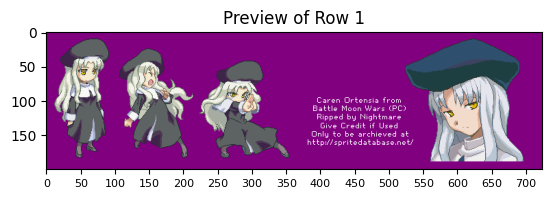

Enter motion name for frames in row 0 (or 'skip' to skip this row, or 'done' if finished with this row):  attack
Enter left coordinate:  0
Enter right coordinate:  360


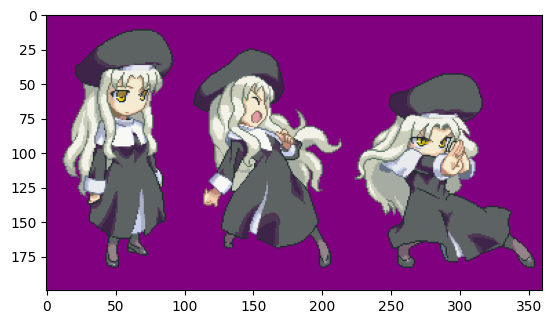

Is this segmentation correct? Type 'ok' to confirm or 'retry' to re-enter:  ok


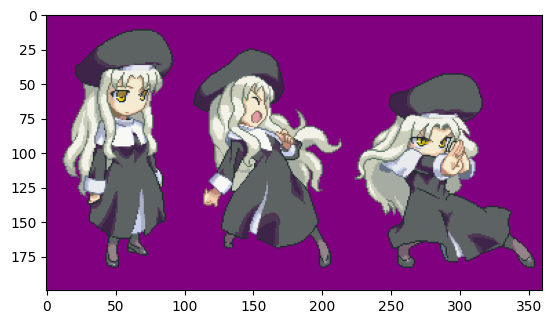

Enter the width of each frame:  100


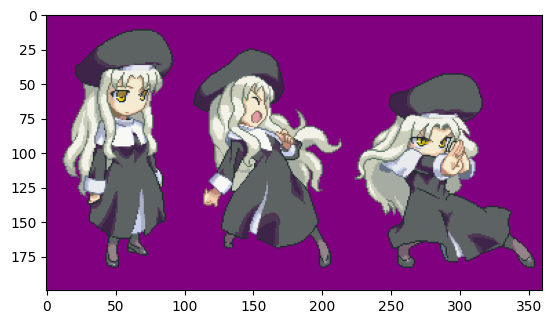

Enter the start point for frame 0 0


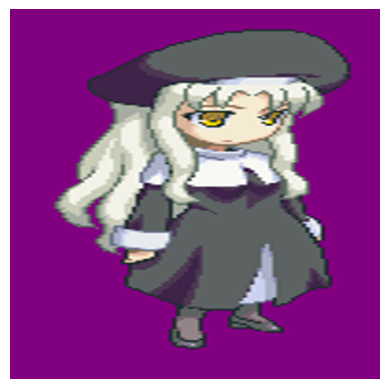

Is this frame correct? Type 'ok' to save and proceed, 'done' to move to the next, or 'retry' to redefine width:  ok


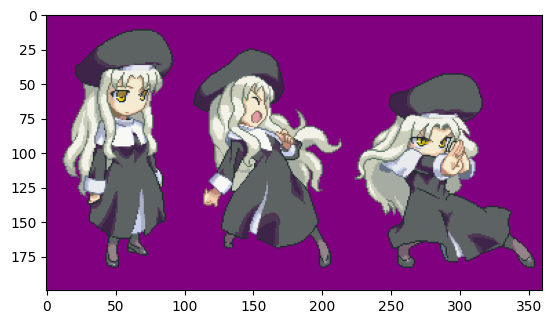

Enter the start point for frame 1 110


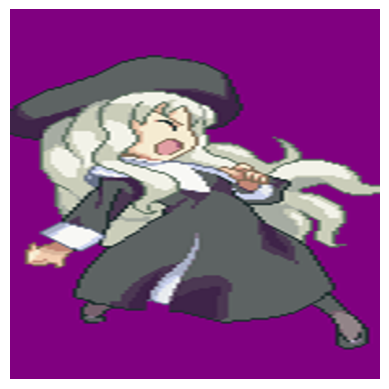

Is this frame correct? Type 'ok' to save and proceed, 'done' to move to the next, or 'retry' to redefine width:  ok


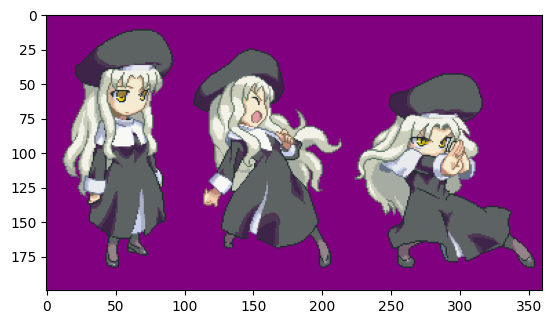

Enter the start point for frame 2 235


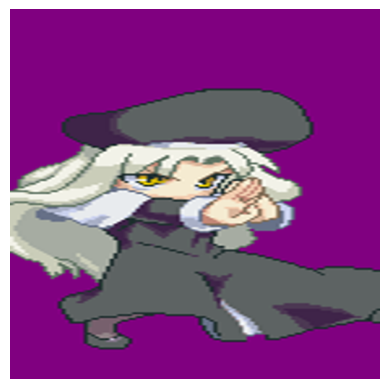

Is this frame correct? Type 'ok' to save and proceed, 'done' to move to the next, or 'retry' to redefine width:  ok


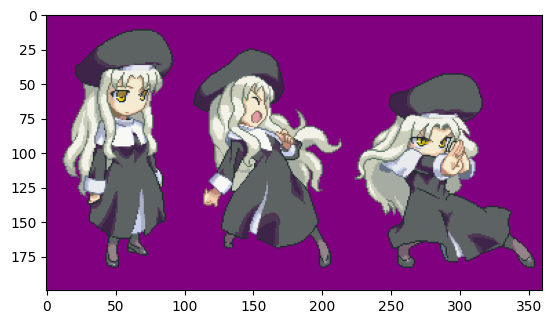

Enter the start point for frame 3 


pass to next motion


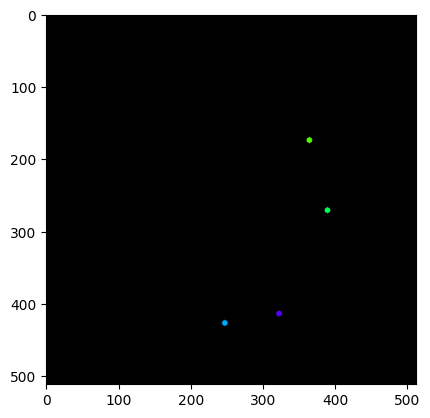

Does it look good? Type 'y' to confirm or 'n' to hand label it n


<class 'PIL.Image.Image'>


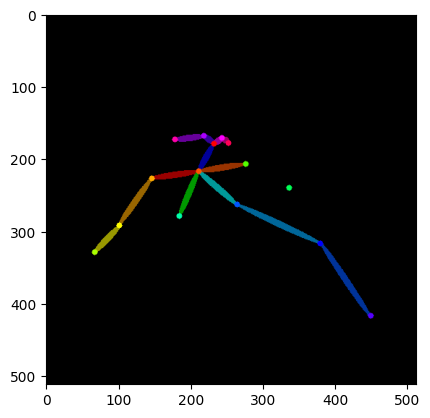

Does it look good? Type 'y' to confirm or 'n' to hand label it n


<class 'PIL.Image.Image'>


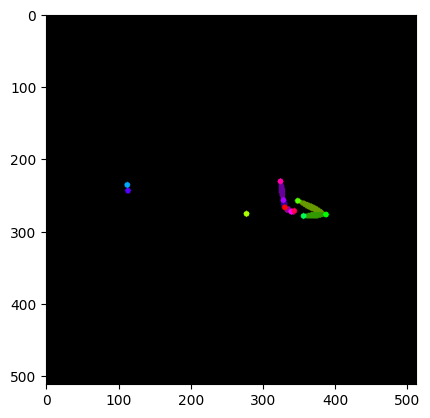

Does it look good? Type 'y' to confirm or 'n' to hand label it n


<class 'PIL.Image.Image'>


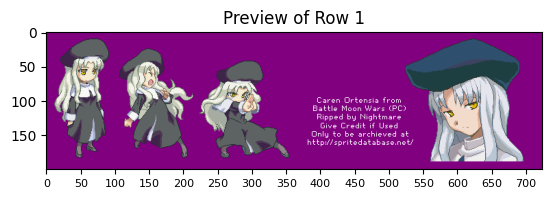

Enter motion name for frames in row 0 (or 'skip' to skip this row, or 'done' if finished with this row):  done


Finished defining motions for row 0.
Cache for row 0 cleared.


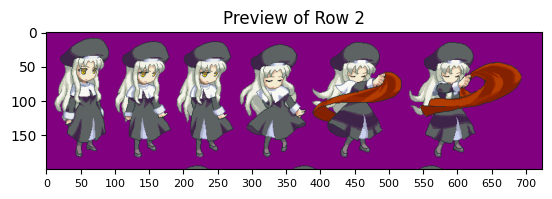

In [ ]:
def process_character_sheet(image_path, character_name):
    character_dir = os.path.join(motion_frames_dir, character_name)
    cache_dir = os.path.join(character_dir, 'cache')
    frames = None
    rows = None

    if not os.path.exists(character_dir):
        os.mkdir(character_dir)
    # Check if the character has already been processed completely
    elif os.path.exists(os.path.join(character_dir, 'main.png')) and not os.path.exists(cache_dir):
        print(f"{character_name} has already been fully processed. Skipping.")
        return

    # Check if cache exists
    if not os.path.exists(cache_dir):
        # Open the image
        image = Image.open(image_path)
        print(f"Processing {character_name}...")

        # Step 2: Define motion part for segmentation
        x, y, w, h, rows = define_motion_part(image)

        # Crop the image to motion part
        motion_part = image.crop((x, y, x + w, y + h))

        # Step 3: Define frame width and height and segment frames
        rows = segment_frames(motion_part, rows)

    # Step 4: Define motions and save frames with caching
    define_and_save_motions(character_dir,rows)
        
# Set up directories
spritesheet_dir = 'spritesheet'
motion_frames_dir = 'motion_frames'

# Ensure motion_frames directory exists
if not os.path.exists(motion_frames_dir):
    os.makedirs(motion_frames_dir)

# Iterate over the character sheet images
for filename in os.listdir(spritesheet_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        character_name = os.path.splitext(filename)[0]
        image_path = os.path.join(spritesheet_dir, filename)
        process_character_sheet(image_path, character_name)